# Demo of modflow-obs
This page demonstrates some of the core features of modflow-obs. Specifically:

* creation of 'base' head and stream flow observations from time series, including
    * in-tandem processing of observation data and MODFLOW output
    * creation of instruction files
* creating of derivative observations from the base observations, including
    * sequential temporal changes in observation values at a site
    * time series of displacement from a reference observation at a site
    * time series of differences between observed values at two sites
    
    
References:  
[Modflow-setup package](https://github.com/aleaf/modflow-setup)  
[Affine package](https://github.com/sgillies/affine)

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


## Inputs

Input and output paths

In [2]:
data_path = Path('../mfobs/tests/data/shellmound/')

output_folder = Path('output')
output_folder.mkdir(exist_ok=True)  # make the output folder if it doesn't exist

### model grid definition
read the model grid json file created by ``modflow-setup`` and create an ``affine.Affine`` instance describing the grid orientation

In [3]:
from mfobs.modflow import get_modelgrid_transform

modelgrid_transform = get_modelgrid_transform(data_path / 'shellmound_grid.json')
modelgrid_transform

Affine(1000.0, 0.0, 500955.0,
       0.0, -1000.0, 1205285.0)

### model time discretization
read table of stress period information created by ``modflow-setup``

In [4]:
perioddata = pd.read_csv(data_path / 'tables/stress_period_data.csv')
perioddata.head()

,start_datetime,end_datetime,time,per,perlen,nstp,tsmult,steady
0,1998-04-01,1998-04-01,1.0,0,1.0,1,1.0,True
1,1998-04-01,2007-03-31,3288.0,1,3287.0,10,1.5,False
2,2007-04-01,2007-09-30,3471.0,2,183.0,5,1.5,False
3,2007-10-01,2008-03-31,3654.0,3,183.0,5,1.5,False
4,2008-04-01,2008-09-30,3837.0,4,183.0,5,1.5,False


#### alternatively, get the stress period information from the TDIS and STO files

In [5]:
from mfobs.modflow import get_perioddata

perioddata = get_perioddata(data_path / 'mfsim.tdis', data_path / 'shellmound.sto')
perioddata.head()

,start_datetime,end_datetime,time,per,perlen,nstp,tsmult,steady
0,1998-04-01,1998-04-01,1.0,0,1.0,1,1.0,True
1,1998-04-01,2007-03-31,3288.0,1,3287.0,10,1.5,False
2,2007-04-01,2007-09-30,3471.0,2,183.0,5,1.5,False
3,2007-10-01,2008-03-31,3654.0,3,183.0,5,1.5,False
4,2008-04-01,2008-09-30,3837.0,4,183.0,5,1.5,False


The above "period_data" table has start/end datetimes in MODFLOW time, but often we want a steady-state period to effectively represent a different time period. Define start and end dates that bracket the time period represented by steady-state period 0:

In [6]:
steady_state_period_start = '2008-04-01'
steady_state_period_end = '2008-9-30'

### model property information for T-weighted averaging

In [7]:
top_array = data_path / 'external/top.dat'
botm_arrays = [data_path / 'external/botm{}.dat'.format(i)
               for i in range(13)]
hk_arrays = [data_path / 'external/k{}.dat'.format(i)
             for i in range(13)]

### head observation data
We start with some head observation data that already has

* been culled to model area, reprojected to model CRS, converted to model units, etc.
* open interval information
* `obsnme` (in the PEST parlance) prefixes identifying the sites
* prelimary groupings based on location (optional)

The observation data may or may not be broken into a data table with time series, and a metadata table with site information.

The [USGS-MAP-gwmodels package](https://github.com/aleaf/usgs-map-gwmodels) is one way to create such input data from sources including the USGS National Water Information System (NWIS).

The metadata (site info):

In [8]:
head_obs_info = pd.read_csv(data_path / 'tables/preprocessed_head_obs_info.csv')
head_obs_info.head()

,head,head_std,last_head,n,aqfr_cd,nat_aqfr_cd,screen_botm,screen_top,well_depth,well_el,...,end_dt,site_no,x,y,well_botm,category,orig_scbot,orig_sctop,obsprefix,group
0,32.00,NaN,32.00,1.0,112MRVA,N100MSRVVL,NaN,NaN,NaN,39.05,...,2018-10-01,USGS:333034090150501,530104.14,1176208.54,NaN,4,NaN,NaN,USGS:333034090150501,heads
1,26.21,NaN,26.21,1.0,112MRVA,N100MSRVVL,-3.35,14.94,136.0,38.10,...,2006-09-01,USGS:333040090200601,522383.51,1175944.23,-97.90,3,-3.35,14.94,USGS:333040090200601,heads
2,33.15,0.0,33.15,1.6,112MRVA,N100MSRVVL,-69.38,-57.18,109.0,39.62,...,2002-04-01,USGS:333050090153001,529954.56,1176430.50,-69.38,2,NaN,NaN,USGS:333050090153001,heads
3,20.73,NaN,20.73,1.0,112MRVA,N100MSRVVL,-1.52,10.67,125.0,36.58,...,2002-06-01,USGS:333113090232001,517359.53,1176671.36,-88.42,3,-1.52,10.67,USGS:333113090232001,heads
4,22.83,NaN,22.83,1.0,112MRVA,N100MSRVVL,NaN,NaN,NaN,37.19,...,2000-10-01,USGS:333113090244701,515142.49,1176527.26,NaN,4,NaN,NaN,USGS:333113090244701,heads


Time series of head at the locations in the metadata:

In [9]:
head_obs = pd.read_csv(data_path / 'tables/preprocessed_head_obs.csv')
head_obs.head()

,site_no,datetime,head,last_head,head_std,n,obsprefix
0,USGS:333034090150501,1999-04-01,32.37,32.37,NaN,1,USGS:333034090150501
1,USGS:333034090150501,2000-10-01,31.54,31.54,NaN,1,USGS:333034090150501
2,USGS:333034090150501,2001-04-01,32.60,32.60,NaN,1,USGS:333034090150501
3,USGS:333034090150501,2001-10-01,31.96,31.96,NaN,1,USGS:333034090150501
4,USGS:333034090150501,2002-04-01,33.35,33.35,NaN,1,USGS:333034090150501


### streamflow observations
Flux observation inputs are similar to heads, except the metadata aren't needed

* only a site number, datetime, and values column are required
* Note: site numbers are handled as strings. Site numbers with leading zeros (such as those for many USGS gages) must be specified as strings when read by pandas, otherwise they will be cast to integers by default, and not match the MODFLOW observation names

In [10]:
flux_obs = pd.read_csv(data_path / 'tables/processed_flow_obs.csv', dtype={'site_no': object})
flux_obs.head()

,site_no,datetime,category,est_qtotal_m3d,est_qbase_m3d,meas_qtotal_m3d,meas_qbase_m3d,obsval
0,07281600,2008-01-01,measured,NaN,NaN,10215000.0,6403120.0,6403120.0
1,07281600,2008-02-01,measured,NaN,NaN,15611700.0,5332650.0,5332650.0
2,07281600,2008-03-01,measured,NaN,NaN,20682200.0,15022400.0,15022400.0
3,07281600,2008-04-01,measured,NaN,NaN,24353200.0,12339100.0,12339100.0
4,07281600,2008-05-01,measured,NaN,NaN,22076000.0,13931500.0,13931500.0


### MODFLOW-6 observation input

* the MODFLOW observation names (representing sites) must match those in the ``obsprefix`` column of the preprocessed head data above
* a key feature of **Modflow-obs** is computation of simulated heads from transmissivity-weighted averages of the head values simulated for the layers that intersect each well open interval. To take advantage of this feature, for each location (site), a MODFLOW observation must be entered for each layer.
* [Modflow-setup](https://github.com/aleaf/modflow-setup) can create MODFLOW-6 observation input (with an observation in each layer) automatically, using the locations and ``obsprefixes`` in the above metadata file

In [11]:
headobs_input_file = data_path / 'shellmound.obs'

with open(headobs_input_file) as src:
    print(src.read()[:500])

BEGIN options
  DIGITS  10
  PRINT_INPUT
END options

BEGIN continuous  FILEOUT  shellmound.head.obs
  usgs:333145090261901  HEAD  1 28 12
  usgs:333145090261901  HEAD  2 28 12
  usgs:333145090261901  HEAD  3 28 12
  usgs:333145090261901  HEAD  4 28 12
  usgs:333145090261901  HEAD  5 28 12
  usgs:333145090261901  HEAD  6 28 12
  usgs:333145090261901  HEAD  7 28 12
  usgs:333145090261901  HEAD  8 28 12
  usgs:333145090261901  HEAD  9 28 12
  usgs:333145090261901  HEAD  10 28 12
  usgs:33314509026


* **flux observation in input** to MODFLOW is not needed by modflow-obs because there aren't layers to sort out, but like head observations, the site identifiers supplied to MODFLOW must match those in the observation data file above

### MODFLOW-6 observation output
* simulated values at observation locations are returned in a csv file with model timesteps along the row axis, and individual observation locations (1 per layer) along the column axis

In [12]:
headobs_output_file = data_path / 'shellmound.head.obs'
with open(headobs_output_file) as src:
    print('\n'.join([l[:100] for l in src.readlines()[:2]]))

time,USGS:333145090261901,USGS:333145090261901,USGS:333145090261901,USGS:333145090261901,USGS:333145
1.000000000000,29.61748720,29.62154020,29.62504962,29.62677031,29.62761331,29.62882679,29.63409325,2


* SFR package observations are similar

In [13]:
fluxobs_output_file = data_path / 'shellmound.sfr.obs.output.csv'

with open(fluxobs_output_file) as src:
    print(''.join([l for l in src.readlines()[:4]]))

time,07288280,07288580,07288500,07281600
1,0,-1805.6,0,-8.203e+06
30.0038,0,-901.46,0,-8.2845e+06
73.5094,0,0,0,-8.2622e+06



## Create a base set of head observations

* reads head observation data and model output and matches values
    * by location using the ``obsprefix`` names
    * in time by averaging observed values to the model stress period
    * optionally, a model stress period can be labeled as steady-state (``label_period_as_steady_state``), representing average conditions over a time period bracked by a ``steady_state_period_start`` and ``steady_state_period_end``. In this case, the simulated values for the labeled stress period are matched to average values for the steady-state time period.
* the model output are assumed to include all layers at each observation location; observation names in the model output are assumed to correspond to ``obsprefix``es in the head observation data
* observation layer can be specified explicitly via an ``observed_values_layer_col`` in the head observation data, or, the simulated values can be averaged vertically with transmissivity-based weighting (``observed_values_layer_col=None``). In the latter case, model property arrays (``hk_arrays``, ``top_array``, ``botm_arrays``) must be supplied. At observation sites without open interval information, all model layers are included in the transmissivity-weighted averaging.
* observation names to match observed values to their simulated equivalents are constructed in the format of ``<obsprefix>_<date suffix>``, where obsprefix is a site identifier taken from the ``observed_values_site_id_col`` in ``observed_values_file``, and the date suffix is controlled by the ``obsnme_date_suffix_format`` parameter (default of ``'%Y%m'``). Steady-state observations are assigned a suffix of ``'ss'``.
* simulated and observed values are written to columns formatted with ``sim_`` or ``obs_<variable_name>``

In [14]:
from mfobs.heads import get_head_obs

base_obs = get_head_obs(perioddata,
                        modelgrid_transform=modelgrid_transform,
                        model_output_file=headobs_output_file,
                        observed_values_file=head_obs,
                        observed_values_metadata_file=head_obs_info,
                        observed_values_obsval_col='head',
                        gwf_obs_input_file=headobs_input_file,
                        hk_arrays=hk_arrays,
                        top_array=top_array,
                        botm_arrays=botm_arrays,
                        label_period_as_steady_state=0,
                        steady_state_period_start=steady_state_period_start,
                        steady_state_period_end=steady_state_period_end,
                        write_ins=True, 
                        outfile=output_folder / 'processed_head_obs.dat'
                        )
base_obs.head()

reading model output from ../mfobs/tests/data/shellmound/shellmound.head.obs...
Dropping 191 sites with no information


/Users/aleaf/Documents/GitHub/modflow-obs/mfobs/heads.py:381: UserWarning: Stress period 8: No observations between start and end dates of 2010-04-01 and 2010-09-30!
  warnings.warn(('Stress period {}: No observations between start and '


wrote 581 observations to output/processed_head_obs.dat
wrote 581 observation instructions to output/processed_head_obs.dat.ins


,datetime,per,obsprefix,obsnme,obs_head,sim_head,n,screen_top,screen_botm,obsval,obgnme
obsnme,,,,,,,,,,,
usgs:333145090261901_201409,2014-09-30,16,usgs:333145090261901,usgs:333145090261901_201409,20.906667,28.948277,27,-16.01,-28.20,20.906667,head
usgs:333145090261901_201503,2015-03-31,17,usgs:333145090261901,usgs:333145090261901_201503,20.985000,29.139451,181,-16.01,-28.20,20.985000,head
usgs:333145090261901_201509,2015-09-30,18,usgs:333145090261901,usgs:333145090261901_201509,21.060000,29.057794,181,-16.01,-28.20,21.060000,head
usgs:333218090271101_ss,2008-09-30,0,usgs:333218090271101,usgs:333218090271101_ss,19.320000,30.279858,2,-102.15,-114.34,19.320000,head
usgs:333218090271101_200703,2007-03-31,1,usgs:333218090271101,usgs:333218090271101_200703,20.111250,28.161395,8,-102.15,-114.34,20.111250,head


### PEST instruction files
Can be written in tandem with the processed observation output (``write_ins=True``). This way, 

* observation processing functions like ``get_head_obs`` can be used initially to get an instruction file and a set of observed values for making a PEST control file
* and subsequently for processing model output during a PEST run, that can then be read by PEST via the instruciton file

In [15]:
with open('output/processed_head_obs.dat.ins') as src:
    print(''.join([l for l in src.readlines()[:4]]))

pif @
@obsnme@
l1 w w w w w !usgs:333145090261901_201409! w w w w w
l1 w w w w w !usgs:333145090261901_201503! w w w w w



### plot base data for a site

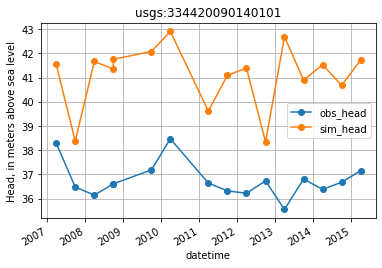

In [16]:
site = 'usgs:334420090140101'
site_values = base_obs.loc[base_obs.obsprefix == site, ['datetime', 'obs_head', 'sim_head', 'obsnme']].copy()
site_values.index = site_values.datetime
ax = site_values[['obs_head', 'sim_head']].plot(marker='o')
ax.set_title(site)
ax.set_ylabel('Head, in meters above sea level')
ax.grid()

## Changes in head through time
The base values returned by ``get_head_obs`` can be processed further into temporal head differences: 

* similar to ``get_head_obs`` the ``get_temporal_differences`` function can also write an instruction file in tandem
* by default, sequential differences are computed by subtracting the previous time from the current,
    so a positive value indicates an increase.
* Sequential difference observations can help inform PEST about seasonal trends in the observation data.

In [17]:
from mfobs.obs import get_temporal_differences

thead_diffs = get_temporal_differences(base_obs,
                                       perioddata,
                                       obs_values_col='obs_head',
                                       sim_values_col='sim_head',
                                       obstype='head',
                                       write_ins=True,
                                       outfile=output_folder / 'processed_head_obs_tdiffs.dat')

wrote 499 observations to output/processed_head_obs_tdiffs.dat
wrote 499 observation instructions to output/processed_head_obs_tdiffs.dat.ins


### plot temporal head differences for a site

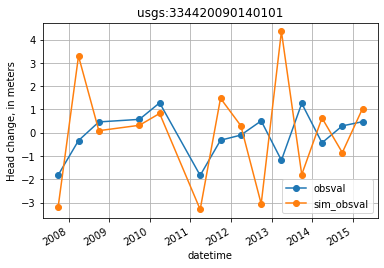

In [18]:
site = 'usgs:334420090140101'
site_values = thead_diffs.loc[thead_diffs.obsprefix == site, ['datetime', 'obsval', 'sim_obsval', 'obsnme']].copy()
site_values.index = site_values.datetime
ax = site_values[['obsval', 'sim_obsval']].plot(marker='o')
ax.set_title(site)
ax.set_ylabel('Head change, in meters')
ax.grid()

## Displacement in head through time
The ``get_temporal_differences`` function can also be used to compute displacement (total change) from a reference time, via the ``get_displacement`` flag. 
* Displacements are computed at sites with 2 or more observations. 
* The reference time is specified by the ``displacement_from`` argument. 
    * The first observation at each site that occurs on or after the reference time is then used as the datum in computing the displacements. 
    * If no reference time is specified, the first observation is used as the datum for each site.
* Displacement observations can help inform PEST about longer-term temporal trends in the observation data.

In [19]:
thead_disp = get_temporal_differences(base_obs,
                                       perioddata,
                                       obs_values_col='obs_head',
                                       sim_values_col='sim_head',
                                       obstype='head',
                                       get_displacements=True,
                                       displacement_from='2010-01-01',
                                       write_ins=True,
                                       outfile=output_folder / 'processed_head_obs_disp.dat')

/Users/aleaf/opt/anaconda3/envs/gis/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


wrote 292 observations to output/processed_head_obs_disp.dat
wrote 292 observation instructions to output/processed_head_obs_disp.dat.ins


### Plot the displacement observations
Note: the datum observation (where displacement is zero) is excluded.

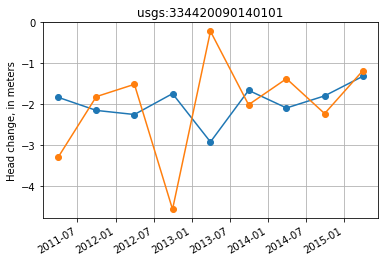

In [20]:
site = 'usgs:334420090140101'
site_values = thead_disp.loc[thead_disp.obsprefix == site, ['datetime', 'obsval', 'sim_obsval', 'obsnme']].copy()

# for some reason, pd.DataFrame.plot() incorrectly shifts the xticks in this case
fig, ax = plt.subplots()
ax.plot(site_values.datetime, site_values.obsval, marker='o')
ax.plot(site_values.datetime, site_values.sim_obsval, marker='o')
ax.set_title(site)
ax.set_ylabel('Head change, in meters')
fig.autofmt_xdate()
ax.grid()

## Head differences between sites

Similarly, the base values returned by ``get_head_obs`` can also be processed into spatial head differences. 
These may represent nested wells, well-lake differences or simply two nearby wells that represent an important
head gradient.

* similar to ``get_head_obs`` the ``get_spatial_differences`` function can also write an instruction file in tandem

In [21]:
from mfobs.obs import get_spatial_differences

head_difference_sites = {'usgs:333904090123801':  # well in money, ms
                         'usgs:333145090261901'  # well approx. 15 mi southwest in cone of depression
                             }

shead_diffs = get_spatial_differences(base_obs,
                                      perioddata,
                                      difference_sites=head_difference_sites,
                                      obs_values_col='obs_head',
                                      sim_values_col='sim_head',
                                      obstype='head',
                                      write_ins=True,
                                      outfile=output_folder / 'processed_head_obs_sdiffs.dat')

wrote 3 observations to output/processed_head_obs_sdiffs.dat
wrote 3 observation instructions to output/processed_head_obs_sdiffs.dat.ins


In [22]:
shead_diffs.head()

,datetime,per,obsprefix,obsnme1,obs_head1,sim_head1,screen_top1,screen_botm1,obsnme2,obs_head2,...,obs_diff,sim_diff,dz,obs_grad,sim_grad,obgnme,obsnme,obsval,sim_obsval,type
per,,,,,,,,,,,,,,,,,,,,,
16,2014-09-30,16,usgs:333904090123801-d-usgs:333145090261901,usgs:333904090123801_201409,35.163333,40.340913,23.15,10.96,usgs:333145090261901_201409,20.906667,...,14.256667,11.392636,39.16,0.364062,0.290925,head_sdiff,usgs:333904090123801-d-usgs:333145090261901_20...,14.256667,11.392636,spatial head difference
17,2015-03-31,17,usgs:333904090123801-d-usgs:333145090261901,usgs:333904090123801_201503,35.258333,41.410755,23.15,10.96,usgs:333145090261901_201503,20.985000,...,14.273333,12.271304,39.16,0.364488,0.313363,head_sdiff,usgs:333904090123801-d-usgs:333145090261901_20...,14.273333,12.271304,spatial head difference
18,2015-09-30,18,usgs:333904090123801-d-usgs:333145090261901,usgs:333904090123801_201509,35.358333,40.785719,23.15,10.96,usgs:333145090261901_201509,21.060000,...,14.298333,11.727924,39.16,0.365126,0.299487,head_sdiff,usgs:333904090123801-d-usgs:333145090261901_20...,14.298333,11.727924,spatial head difference


Text(0, 0.5, 'Head difference, in meters')

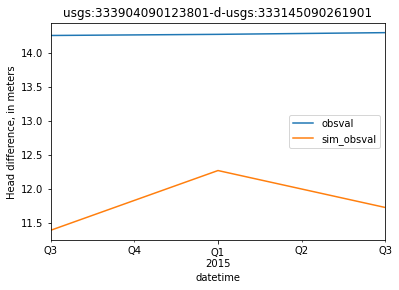

In [23]:
site = shead_diffs.obsprefix.values[0]
site_values = shead_diffs.loc[shead_diffs.obsprefix == site, ['datetime', 'obsval', 'sim_obsval', 'obsnme']].copy()
site_values.index = site_values.datetime
ax = site_values[['obsval', 'sim_obsval']].plot()
ax.set_title(site)
ax.set_ylabel('Head difference, in meters')

## Create a base set of flux observations

* similar to head observations, the first step in flux observation processing is to create a set of base observations
* observation data and model output are read and matched
    * by location using the ``obsprefix`` names
    * in time by averaging observed values to the model stress period
    * optionally, a model stress period can be labeled as steady-state (``label_period_as_steady_state``), representing average conditions over a time period bracked by a ``steady_state_period_start`` and ``steady_state_period_end``. In this case, the simulated values for the labeled stress period are matched to average values for the steady-state time period.
* observation names to match observed values to their simulated equivalents are constructed in the format of ``<obsprefix>_<date suffix>``, where obsprefix is a site identifier taken from the ``observed_values_site_id_col`` in ``observed_values_file``, and the date suffix is controlled by the ``obsnme_date_suffix_format`` parameter (default of ``'%Y%m'``). Steady-state observations are assigned a suffix of ``'ss'``.
* simulated and observed values are written to columns formatted with ``sim_`` or ``obs_<variable_name>``

In [24]:
from mfobs.swflows import get_flux_obs

base_flux_obs = get_flux_obs(perioddata,
                             model_output_file=fluxobs_output_file,
                             observed_values_file=flux_obs,
                             observed_values_site_id_col='site_no',
                             observed_values_datetime_col='datetime',
                             observed_values_obsval_col='obsval',
                             label_period_as_steady_state=0,
                             steady_state_period_start=steady_state_period_start,
                             steady_state_period_end=steady_state_period_end,
                             write_ins=True, 
                             outfile=output_folder / 'processed_flux_obs.dat'
                             )
base_flux_obs.head()

reading model output from ../mfobs/tests/data/shellmound/shellmound.sfr.obs.output.csv...
Dropping 1 sites with no information
wrote 53 observations to output/processed_flux_obs.dat
wrote 53 observation instructions to output/processed_flux_obs.dat.ins


,datetime,per,obsprefix,obsnme,obs_flux,sim_flux,obsval,obgnme
obsnme,,,,,,,,
07281600_ss,2008-09-30,0,07281600,07281600_ss,1.349688e+07,8203000.0,1.349688e+07,flux
07281600_200803,2008-03-31,3,07281600,07281600_200803,8.919390e+06,7155800.0,8.919390e+06,flux
07281600_200809,2008-09-30,4,07281600,07281600_200809,1.349688e+07,6290400.0,1.349688e+07,flux
07281600_200903,2009-03-31,5,07281600,07281600_200903,1.547445e+07,6740000.0,1.547445e+07,flux
07281600_200909,2009-09-30,6,07281600,07281600_200909,1.365627e+07,7182900.0,1.365627e+07,flux


In [25]:
base_flux_obs.obsprefix.unique()

array(['07281600', '07288280', '07288500'], dtype=object)

Text(0, 0.5, 'Base flow, in $m^3/d$')

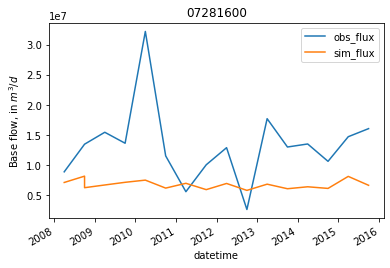

In [26]:
site = '07281600'
site_values = base_flux_obs.loc[base_flux_obs.obsprefix == site, ['datetime', 'obs_flux', 'sim_flux', 'obsnme']].copy()
site_values.index = site_values.datetime
ax = site_values[['obs_flux', 'sim_flux']].plot()
ax.set_title(site)
ax.set_ylabel('Base flow, in $m^3/d$')

## Changes in streamflow through time
Similar to heads, the ``get_temporal_differences`` function can be used to create observations of the changes in streamflow through time at each site.

* Differences are computed by subtracting the previous time from the current,
    so a positive value indicates an increase.

In [27]:
flux_tdiff = get_temporal_differences(base_flux_obs,
                                      perioddata,
                                      obs_values_col='obs_flux',
                                      sim_values_col='sim_flux',
                                      obstype='flux',
                                      write_ins=True,
                                      outfile=output_folder / 'processed_flux_obs_tdiffs.dat')

wrote 47 observations to output/processed_flux_obs_tdiffs.dat
wrote 47 observation instructions to output/processed_flux_obs_tdiffs.dat.ins


In [28]:
flux_tdiff.head()

,datetime,per,obsprefix,obsnme,obs_flux,sim_flux,obsval,sim_obsval,obgnme,type
1,2008-09-30,4,07281600,07281600_200809d200803,1.349688e+07,6290400.0,4.577493e+06,-865400.0,flux_tdiff,temporal flux difference
2,2009-03-31,5,07281600,07281600_200903d200809,1.547445e+07,6740000.0,1.977567e+06,449600.0,flux_tdiff,temporal flux difference
3,2009-09-30,6,07281600,07281600_200909d200903,1.365627e+07,7182900.0,-1.818178e+06,442900.0,flux_tdiff,temporal flux difference
4,2010-03-31,7,07281600,07281600_201003d200909,3.217932e+07,7544900.0,1.852304e+07,362000.0,flux_tdiff,temporal flux difference
5,2010-09-30,8,07281600,07281600_201009d201003,1.156270e+07,6223100.0,-2.061661e+07,-1321800.0,flux_tdiff,temporal flux difference


Text(0, 0.5, 'Change in streamflow, $m^3/d$')

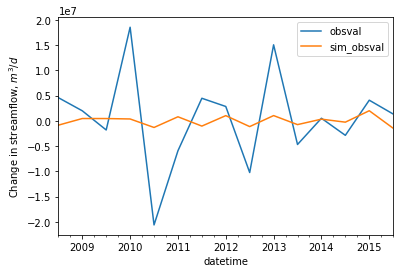

In [29]:
flux_tdiff.index = flux_tdiff.datetime
site = '07281600'
site_data = flux_tdiff.loc[flux_tdiff.obsprefix == site].copy()
ax = site_data[['obsval', 'sim_obsval']].plot()
ax.set_ylabel('Change in streamflow, $m^3/d$')

## Change in streamflow between two sites
Similar to heads, the ``get_spatial_differences`` function can be used to difference stream flows between sites to create observations of stream flow gain or loss.

* Differences are computed by subtracting the values site(s) from the key site, so for example, to represent a gain in streamflow as positive, the downstream site should be key site.

In [30]:
flux_difference_sites = {'07288500':   # sunflower r. at sunflower
                         '07288280'  # sunflower r. at merigold
                         }

flux_sdiff = get_spatial_differences(base_flux_obs, perioddata,
                                     flux_difference_sites,
                                     obs_values_col='obs_flux',
                                     sim_values_col='sim_flux',
                                     obstype='flux',
                                     write_ins=True,
                                     outfile=output_folder / 'processed_flux_obs_sdiffs.dat')

wrote 17 observations to output/processed_flux_obs_sdiffs.dat
wrote 17 observation instructions to output/processed_flux_obs_sdiffs.dat.ins


In [31]:
flux_sdiff.head()

,datetime,per,obsprefix,obsnme1,obs_flux1,sim_flux1,obsnme2,obs_flux2,sim_flux2,obs_diff,sim_diff,obgnme,obsnme,obsval,sim_obsval,type
per,,,,,,,,,,,,,,,,
0,2008-09-30,0,07288500-d-07288280,07288500_ss,816717.0,0.0,07288280_ss,274565.500000,0.0,542151.500000,0.0,flux_sdiff,07288500-d-07288280_ss,542151.500000,0.0,spatial flux difference
3,2008-03-31,3,07288500-d-07288280,07288500_200803,425160.0,0.0,07288280_200803,255581.650000,0.0,169578.350000,0.0,flux_sdiff,07288500-d-07288280_200803,169578.350000,0.0,spatial flux difference
4,2008-09-30,4,07288500-d-07288280,07288500_200809,816717.0,0.0,07288280_200809,274565.500000,0.0,542151.500000,0.0,flux_sdiff,07288500-d-07288280_200809,542151.500000,0.0,spatial flux difference
5,2009-03-31,5,07288500-d-07288280,07288500_200903,468096.5,0.0,07288280_200903,280535.333333,0.0,187561.166667,0.0,flux_sdiff,07288500-d-07288280_200903,187561.166667,0.0,spatial flux difference
6,2009-09-30,6,07288500-d-07288280,07288500_200909,976710.5,0.0,07288280_200909,570437.333333,0.0,406273.166667,0.0,flux_sdiff,07288500-d-07288280_200909,406273.166667,0.0,spatial flux difference


Text(0, 0.5, 'Gain in streamflow, $m^3/d$')

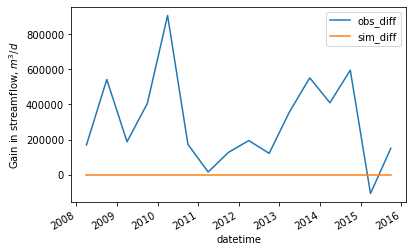

In [32]:
flux_sdiff.index = flux_sdiff.datetime
ax = flux_sdiff[['obs_diff', 'sim_diff']].plot()
ax.set_ylabel('Gain in streamflow, $m^3/d$')